In [1]:
import torch
import torch.optim as optim
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import copy
import numpy as np
import os


In [5]:


def load_image(image_path, max_size=400, shape=None):
    """
    Load and transform an image from a given path.
    
    Parameters:
    - image_path (str): Path to the image file.
    - max_size (int): Maximum size for the larger dimension of the image.
    - shape (tuple): Desired shape for the output image. If provided, overrides max_size.

    Returns:
    - torch.Tensor: Transformed image tensor.
    """
    image = Image.open(image_path).convert('RGB')
    
    # Determine the size for resizing the image
    if shape:
        size = shape
    else:
        size = min(max(image.size), max_size)
        
    # Define the transformation pipeline
    in_transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
    
    # Apply the transformations to the image
    image = in_transform(image)[:3, :, :].unsqueeze(0)
    
    return image

def im_convert(tensor):
    """
    Convert a tensor to a NumPy array suitable for displaying as an image.
    
    Parameters:
    - tensor (torch.Tensor): Image tensor to convert.

    Returns:
    - numpy.ndarray: Converted image in NumPy array format.
    """
    # Clone the tensor and detach it from the computational graph
    image = tensor.to("cpu").clone().detach()
    
    # Convert the tensor to a NumPy array and rearrange the dimensions
    image = image.numpy().squeeze()
    image = image.transpose(1, 2, 0)
    
    # Unnormalize the image
    image = image * (0.229, 0.224, 0.225) + (0.485, 0.456, 0.406)
    
    # Clip the image pixel values to be within the valid range
    image = image.clip(0, 1)
    
    return image
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

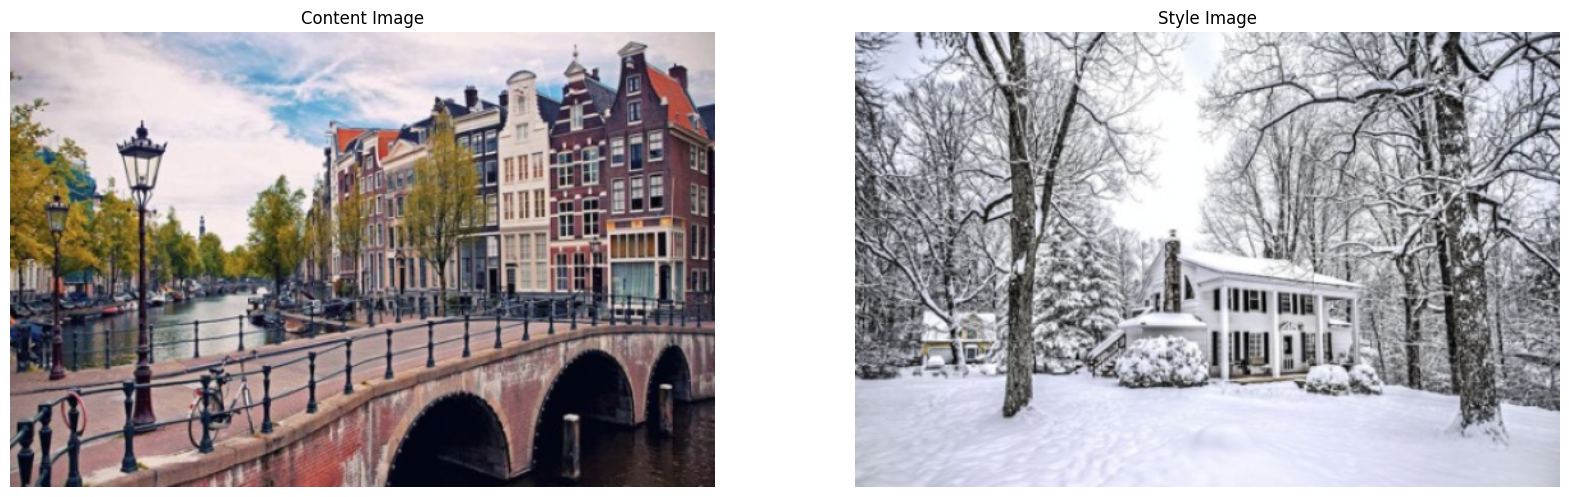

In [6]:


# Define the paths to the content and style images
content_image_path = 'C:\\Users\\kunal\\OneDrive\\Pictures\\content.jpg'
style_image_path = 'C:\\Users\\kunal\\OneDrive\\Pictures\\style.jpg'

# Load and transform the content image
content = load_image(content_image_path).to(device)

# Load and transform the style image, resizing it to match the content image dimensions
style = load_image(style_image_path, shape=content.shape[-2:]).to(device)

# Create a figure with two subplots to display the content and style images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Display the content image
ax1.imshow(im_convert(content))
ax1.set_title("Content Image")
ax1.axis('off')  # Hide the axis

# Display the style image
ax2.imshow(im_convert(style))
ax2.set_title("Style Image")
ax2.axis('off')  # Hide the axis

# Show the figure with the images
plt.show()


In [7]:


# Load the VGG19 model pre-trained with default weights, and use only the feature extractor part
vgg = models.vgg19(weights=models.VGG19_Weights.DEFAULT).features

# Freeze all the parameters of the VGG model, as only the target image will be optimized
for param in vgg.parameters():
    param.requires_grad_(False)

# Move the VGG model to the specified device (e.g., GPU if available)
vgg.to(device)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [8]:
import torch

def get_features(image, model, layers=None):
    """
    Extract features from specific layers of the model.
    
    Parameters:
    - image (torch.Tensor): The input image tensor.
    - model (torch.nn.Module): The pre-trained model.
    - layers (dict): A dictionary mapping layer indices to layer names.
    
    Returns:
    - dict: A dictionary of features from the specified layers.
    """
    if layers is None:
        layers = {
            '0': 'conv1_1',
            '5': 'conv2_1',
            '10': 'conv3_1',
            '19': 'conv4_1',
            '21': 'conv4_2',  # Content layer
            '28': 'conv5_1'
        }
        
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

# Extract features for the content and style images using the VGG model
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

def gram_matrix(tensor):
    """
    Calculate the Gram matrix for a given tensor.
    
    Parameters:
    - tensor (torch.Tensor): The input feature tensor.
    
    Returns:
    - torch.Tensor: The Gram matrix.
    """
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram

# Compute the Gram matrices for each layer in the style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}


In [9]:


def content_loss(target_features, content_features):
    """
    Calculate the content loss between the target and content features.
    
    Parameters:
    - target_features (torch.Tensor): The features of the target image.
    - content_features (torch.Tensor): The features of the content image.
    
    Returns:
    - torch.Tensor: The content loss.
    """
    return torch.mean((target_features - content_features) ** 2)

def style_loss(target_grams, style_grams):
    """
    Calculate the style loss between the target and style Gram matrices.
    
    Parameters:
    - target_grams (dict): The Gram matrices of the target image features.
    - style_grams (dict): The Gram matrices of the style image features.
    
    Returns:
    - torch.Tensor: The total style loss.
    """
    total_style_loss = 0
    for layer in target_grams:
        target_gram = target_grams[layer]
        style_gram = style_grams[layer]
        layer_loss = torch.mean((target_gram - style_gram) ** 2)
        total_style_loss += layer_loss
    return total_style_loss

def total_variation_loss(image):
    """
    Calculate the total variation loss for an image to encourage spatial smoothness.
    
    Parameters:
    - image (torch.Tensor): The input image tensor.
    
    Returns:
    - torch.Tensor: The total variation loss.
    """
    x_diff = image[:, :, 1:, :] - image[:, :, :-1, :]
    y_diff = image[:, :, :, 1:] - image[:, :, :, :-1]
    return torch.sum(torch.abs(x_diff)) + torch.sum(torch.abs(y_diff))


In [10]:


# Create a copy of the content image to be optimized as the target image
target = content.clone().requires_grad_(True).to(device)

# Define the optimizer to optimize the target image
optimizer = optim.Adam([target], lr=0.002)


Step 0, Total Loss: 17239600.0


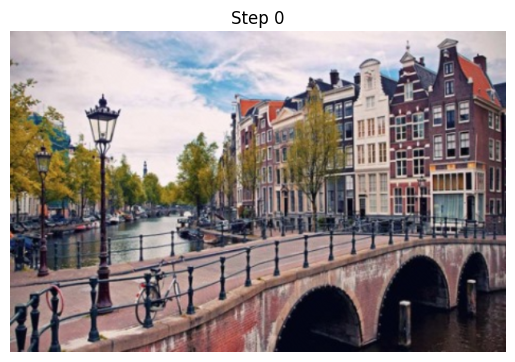

Step 500, Total Loss: 1540110.875


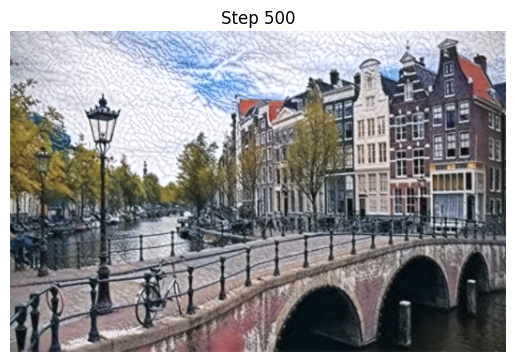

Step 1000, Total Loss: 897090.3125


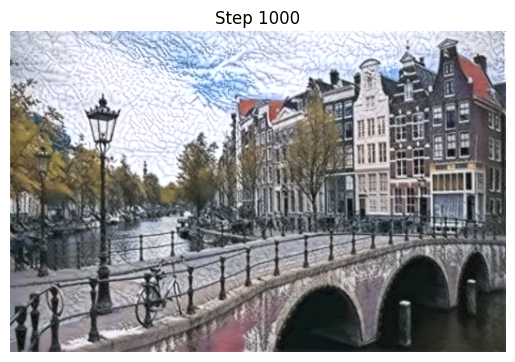

Step 1500, Total Loss: 660499.875


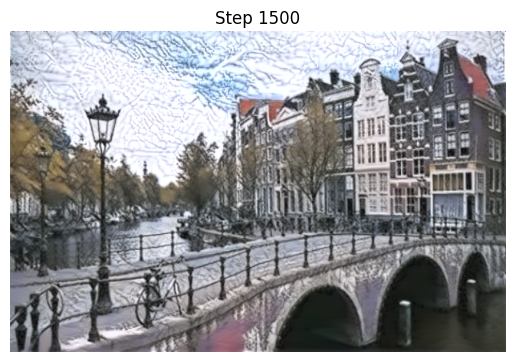

In [11]:
# Define the number of optimization steps
steps = 1550

# Define the weights for the content and style losses
alpha = 1e3
beta = 1e-2

for step in range(steps):
    # Extract the features from the target image
    target_features = get_features(target, vgg)
    
    # Compute the Gram matrices for the target image features
    target_grams = {layer: gram_matrix(target_features[layer]) for layer in target_features}
    
    # Calculate the content loss
    c_loss = content_loss(target_features['conv4_2'], content_features['conv4_2'])
    
    # Calculate the style loss
    s_loss = style_loss(target_grams, style_grams)
    
    # Calculate the total variation loss for smoothness
    tv_loss = total_variation_loss(target)
    
    # Compute the total loss
    total_loss = alpha * c_loss + beta * s_loss + tv_loss
    
    # Zero the gradients of the optimizer
    optimizer.zero_grad()
    
    # Perform backpropagation to compute the gradients
    total_loss.backward()
    
    # Update the target image
    optimizer.step()
    
    # Print the loss and display the image at regular intervals
    if step % 500 == 0:
        print(f"Step {step}, Total Loss: {total_loss.item()}")
        plt.imshow(im_convert(target))
        plt.title(f"Step {step}")
        plt.axis('off')  # Hide the axis for better visualization
        plt.show()


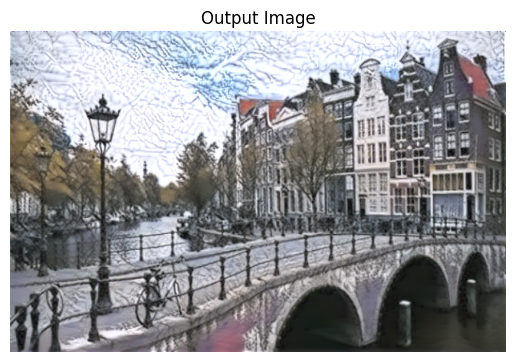

In [12]:
# Convert the target image tensor to a NumPy array suitable for displaying and saving
final_image = im_convert(target)

# Display the final image
plt.imshow(final_image)
plt.title("Output Image")
plt.axis("off")  # Hide the axis for better visualization
plt.show()

# Save the final image to a file
output_path = "output_image.jpg"
final_image_pil = Image.fromarray((final_image * 255).astype(np.uint8))
final_image_pil.save(output_path)
